### VISUALIZE DETECTRON2 RESULTS

This notebook demonstrates how to visualize the results of a Detectron2 model on an image. It uses the `detectron2` library to load a pre-trained model and visualize its predictions on a sample image.

We use it to visualize the results of the model on a sample image. The notebook includes the following steps:

1. **Install Required Libraries**: Install the necessary libraries, including `detectron2`, `opencv-python`, and `matplotlib`.
2. **Import Libraries**: Import the required libraries for image processing and visualization.
3. **Load the Model**: Load a pre-trained Detectron2 model using the `get_detectron_model` function.
4. **Load the Image**: Load a sample image using OpenCV.
5. **Make Predictions**: Use the loaded model to make predictions on the image.
6. **Visualize Results**: Visualize the predictions using OpenCV and Matplotlib.
7. **Display the Image**: Display the image with the predictions using Matplotlib.
8. **Save the Image**: Save the visualized image to a file.

In [1]:
import sys, os, distutils.core

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
%matplotlib ipympl
import matplotlib.pyplot as plt
import logging
import matplotlib
matplotlib.set_loglevel("error")  # Solo muestra errores importantes

import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

##### We must also load the class names for the model to display them in the visualization.

In [ ]:
from detectron2.data.datasets import register_coco_instances
%cd detr/
"""
DatasetCatalog.remove("custom_train")
MetadataCatalog.remove("custom_train")
DatasetCatalog.remove("custom_val")
MetadataCatalog.remove("custom_val")"""

register_coco_instances("custom_train",
                        {},
                        "../../../images/annotations/custom_train.json",
                        "../../../images/train2017/")

register_coco_instances("custom_val",
                        {},
                        "../../../images/annotations/custom_val.json",
                        "../../../images/val2017/")
# Register the dataset

In [3]:
cat_names = ['molec', 'arrow', 'text', 'plus']

for keyword in ['train', 'val']:
  MetadataCatalog.get('custom_{}'.format(keyword)).set(thing_classes=cat_names)

custom_metadata = MetadataCatalog.get("custom_train")

Once loaded the requiered libraries, we can start the process of loading the trained weights into our environment. 

In [ ]:
#%cd detr/

from d2.detr import add_detr_config

cfg = get_cfg()

add_detr_config(cfg)
cfg.merge_from_file("d2/configs/detr_256_6_6_torchvision.yaml")
cfg.OUTPUT_DIR = "outputs_3"     # ADDAPT THE OUTPUT DIRECTORY TO YOUR CHOICE
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")    # By choosing the model_final.pth file, you are using the last checkpoint of the training
cfg.DATASETS.TRAIN = ("custom_train",)
cfg.DATASETS.TEST = ("custom_val",)


[Errno 2] No such file or directory: 'detr/'
/lustre/BIF/nobackup/silva045/ocr/detr/detectron_2/detr


/lustre/BIF/nobackup/silva045/miniforge3/envs/ochemr310/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [6]:
cfg.MODEL.DETR.NUM_CLASSES = 4
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 30000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

In [10]:
from d2.train_net import Trainer

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg)
trainer = Trainer(cfg)
#trainer.resume_or_load(resume=False)
#trainer.train()
predictor = DefaultPredictor(cfg)

[05/02 16:20:26 d2.engine.defaults]: Model:
Detr(
  (detr): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerDecoderLayer(
            (self_

##### Now that we have loaded all the requiered elements, we can start the process of infering images with the model.

Before starting, we will need to run some auxiliary functions that will help us visualize the results

In [11]:
def filter_predictions_from_outputs(outputs,
                                    threshold=0.7,
                                    verbose=True):

  predictions = outputs["instances"].to("cpu")

  if verbose:
    print(list(predictions.get_fields()))

  # Reference: https://github.com/facebookresearch/detectron2/blob/7f06f5383421b847d299b8edf480a71e2af66e63/detectron2/structures/instances.py#L27
  #
  #   Indexing: ``instances[indices]`` will apply the indexing on all the fields
  #   and returns a new :class:`Instances`.
  #   Typically, ``indices`` is a integer vector of indices,
  #   or a binary mask of length ``num_instances``

  indices = [i
            for (i, s) in enumerate(predictions.scores)
            if s >= threshold
            ]

  filtered_predictions = predictions[indices]

  return filtered_predictions

def run_worflow(name, my_image,
                my_model,
                threshold = 0.7,
                verbose=False):  
  outputs = my_model(my_image)

  filtered_predictions = filter_predictions_from_outputs(outputs,
                                                         threshold=threshold,
                                                         verbose=verbose)

  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  out = v.draw_instance_predictions(filtered_predictions)

  # Use matplotlib to display the image
  plt.imshow(out.get_image()[:, :, ::-1])
  plt.axis("off")
  plt.show()
  #Save the image with its name
  #cv2.imwrite(f"images/{name}.jpg", out.get_image()[:, :, ::-1]) # You can save the image with its name by running this line
  return

In [12]:
generated_path = "../../../images/test2017/" # Continue the name with [Epoch number]_it_[Iteration number].png
real_path = "../../../real_data/real/" # Continue the name with the name of the real image file

Also I added a function to get a random image both from the real image dataset and the synthetic image dataset. This function will be used to get a random image from the dataset and visualize the results of the model on that image.

In [13]:
import random
# The number of iterations is the same as the one used in the training

def random_synthetic():
    e = random.randint(0, 5) 
    i = random.randint(0, 199) 
    # Return the path of the synthetic image
    return os.path.join(generated_path, f"Final_reaction_Epoch{e}_it_{i}.png")

def random_real(directory):
    files = os.listdir(directory)
    random_file = random.choice(files)
    return os.path.join(directory, random_file)


## VISUALIZE DETECTRON2 RESULTS

Random file: ../../../images/test2017/Final_reaction_Epoch5_it_119.png


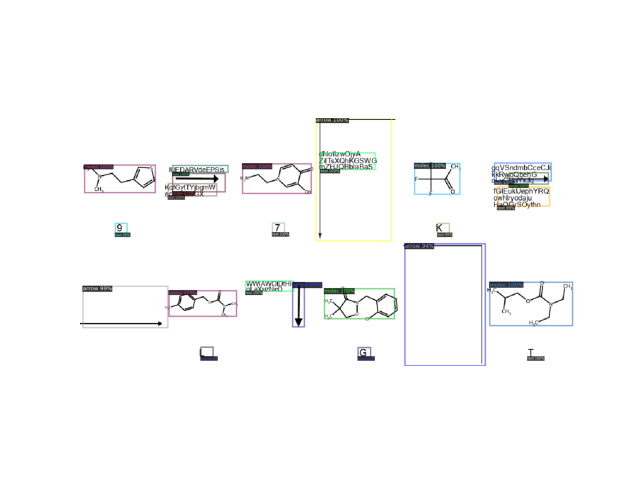

In [14]:
random_file = random_synthetic()
print(f"Random file: {random_file}")
im = cv2.imread(random_file)
if im is None:
    print(f"Image {random_file} not found.")
threshold = 0.7
run_worflow(random_file, im, predictor, threshold=threshold)

Random file: ../../../real_data/real/Tetrodotoxin_2.png


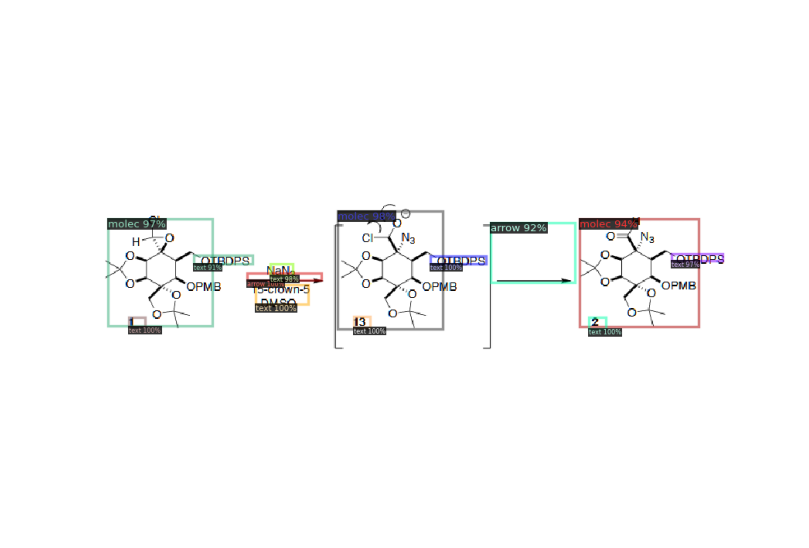

In [18]:
random_file = random_real(real_path)
print(f"Random file: {random_file}")
im = cv2.imread(random_file)
if im is None:
    print(f"Image {random_file} not found.")
threshold = 0.7
run_worflow(random_file, im, predictor, threshold=threshold)

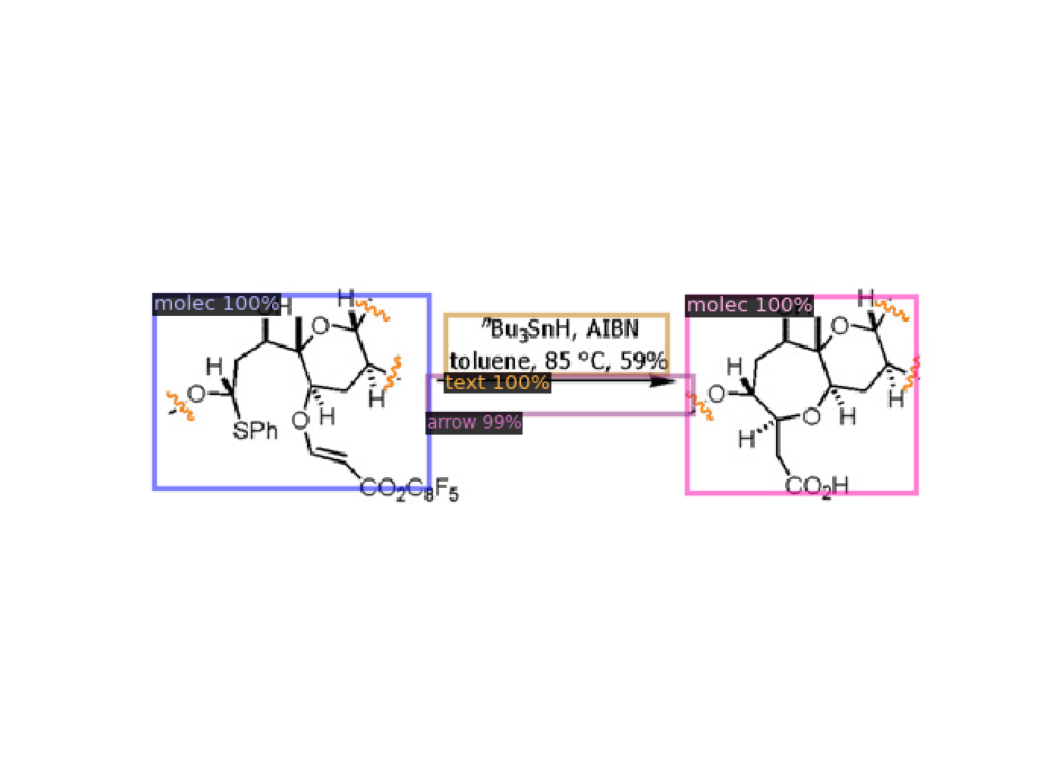

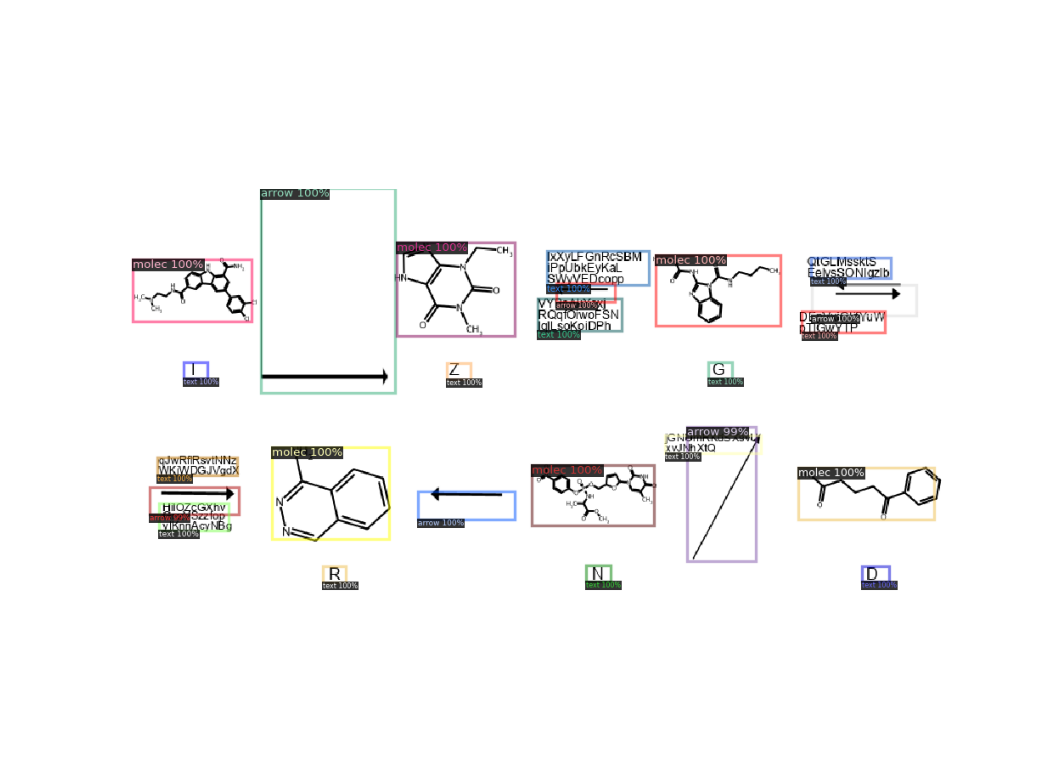

In [55]:
# Get specific image
name = "Ciguatoxin_1.png"
img_name = real_path + name
im = cv2.imread(img_name)

if im is None:
    print(f"Image {img_name} not found.")
threshold = 0.7

run_worflow(name, im, predictor, threshold=threshold)



name = "Final_reaction_Epoch4_it_199.png" # Change image just by changing epoch and iteration
img_name = generated_path + name
im = cv2.imread(img_name)

if im is None:
    print(f"Image {img_name} not found.")
    threshold = 0.7

run_worflow(name, im, predictor, threshold=threshold) 

#### Run Inference on all real images

In case we want to save the inference results of all the images in the dataset, we can use the following code. This code will run inference on all the images in the dataset and save the results to a file. The results will be saved in a folder called `inference_results` in the current directory. The results will be saved in a file called `results.json` in the `inference_results` folder. The results will be saved in a JSON format.


In [60]:
# Run through all the images in the directory real_path
def run_batch_inference(real_path, output_dir, my_model, threshold=0.7, verbose=False):
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(real_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
            img_path = os.path.join(real_path, filename)
            im = cv2.imread(img_path)

            if im is None:
                print(f"❌ Could not read image: {img_path}")
                continue

            outputs = my_model(im)
            filtered_predictions = filter_predictions_from_outputs(outputs, threshold=threshold, verbose=verbose)

            v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
            out = v.draw_instance_predictions(filtered_predictions)

            out_img = out.get_image()[:, :, ::-1]  # Convert back to BGR
            save_path = os.path.join(output_dir, filename)
            cv2.imwrite(save_path, out_img)
            print(f"✅ Saved: {save_path}")

# Run the batch inference
output_dir = "real_inference"
os.makedirs(output_dir, exist_ok=True)
run_batch_inference(real_path, output_dir, predictor, threshold=0.7, verbose=False)

✅ Saved: real_inference/laureatin_1.png
✅ Saved: real_inference/resveratrol_1.png
✅ Saved: real_inference/tricholomalide-a_2.png
✅ Saved: real_inference/debenzoyltashironin_2.png
✅ Saved: real_inference/Tetrodotoxin_2.png
✅ Saved: real_inference/006a.png
✅ Saved: real_inference/Daphmanidine_2.png
✅ Saved: real_inference/Amphidinolide_N_2.png
✅ Saved: real_inference/Trisulfides1.png
✅ Saved: real_inference/288a.png
✅ Saved: real_inference/test29.png
✅ Saved: real_inference/stephacidin-a_1.png
✅ Saved: real_inference/c027_s1.png
✅ Saved: real_inference/012a.png
✅ Saved: real_inference/Deoxyharringtonine_2.png
✅ Saved: real_inference/Dictyodendrin_1.png
✅ Saved: real_inference/217a.png
✅ Saved: real_inference/zygadenime_1.png
✅ Saved: real_inference/Basiliolide1.png
✅ Saved: real_inference/Schmid3.png
✅ Saved: real_inference/Yatakemycin_3.png
✅ Saved: real_inference/methylomuralide_4.png
✅ Saved: real_inference/spirastrellolide_4.png
✅ Saved: real_inference/Ciguatoxin_1.png
✅ Saved: real_